# Clustering and Time Series Analysis
   ### This Model groups tweets into different categories based off of key words. This is an effort to analayze the trend of the twitter data set provided. The text of the tweets are analyzed and given a Jaccard similarity score to correctly categorize it into the corresponding group.
   
   ### It outputs graphs to display the user's who are tweeting the most about the corresponding category. For example the bar graphs display the user who has the most economic tweets etc. Next there are distribution test and skewness to analyze trends within each category. 
   
   ### Next we analyze 2D Clusters by Kmeans to cross reference the clusters of tweets between each group.
   
   ### At the end there is a bonus time series analysis portion that can analyze trends of the tweets by weekday and week.
    

# Important Notes:
    This model is easy to use as you only need to extract tweets with the same format as the dataframe provided below.
        Afterwards, one will simply just input their own csv file to be read into the application.
    This model is easy to follow as each cell clearly demonstrates the steps.
    The words used in each category can be updated / removed at any time to improve the effectiveness of the output.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tweepy
import csv
import os
import pandas as pd

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# !pip3 install -U spacy
# !python3 -m spacy download en_core_web_sm

from sklearn.metrics import jaccard_score

C:\Users\aross\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aross\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aross\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets = pd.read_csv('Recession-June-July-500k-Tweets.csv')
tweets.head()

,Unnamed: 0,User,Date Created,Tweet,Favourite Count,Number of Likes,Retweeet Count,Reply Count,Retweeted Tweet,Language
0,0,Makarov_Igor,2022-07-28 23:59:59+00:00,"It is sad, but we are officially in #recession...",98,0,0,0,NaN,en
1,1,quail_jay,2022-07-28 23:59:56+00:00,@tedcruz Orwell said the greatest threat by so...,1896,0,0,0,NaN,en
2,2,ShibaInuOnly,2022-07-28 23:59:55+00:00,Glad to be part of the 1% that remains bullish...,5,7,2,0,NaN,en
3,3,BenSpin2,2022-07-28 23:59:55+00:00,@HawleyMO I think we'll call this the Hawley r...,9,0,0,0,NaN,en
4,4,RJCass1,2022-07-28 23:59:55+00:00,"@ArowynPitts @BCozatt @MarshaBlackburn FYI, ge...",9092,1,0,0,NaN,en


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500001 entries, 0 to 500000
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       500001 non-null  int64  
 1   User             500001 non-null  object 
 2   Date Created     500001 non-null  object 
 3   Tweet            500001 non-null  object 
 4   Favourite Count  500001 non-null  int64  
 5   Number of Likes  500001 non-null  int64  
 6   Retweeet Count   500001 non-null  int64  
 7   Reply Count      500001 non-null  int64  
 8   Retweeted Tweet  0 non-null       float64
 9   Language         500001 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 38.1+ MB


In [4]:
tweets.columns

Index(['Unnamed: 0', 'User', 'Date Created', 'Tweet', 'Favourite Count',
       'Number of Likes', 'Retweeet Count', 'Reply Count', 'Retweeted Tweet',
       'Language'],
      dtype='object')

In [5]:
text_df = tweets.drop(['Unnamed: 0', 'Date Created', 'Favourite Count',
       'Number of Likes', 'Retweeet Count', 'Reply Count', 'Retweeted Tweet',
       'Language'], axis=1)
text_df.head()

,User,Tweet
0,Makarov_Igor,"It is sad, but we are officially in #recession..."
1,quail_jay,@tedcruz Orwell said the greatest threat by so...
2,ShibaInuOnly,Glad to be part of the 1% that remains bullish...
3,BenSpin2,@HawleyMO I think we'll call this the Hawley r...
4,RJCass1,"@ArowynPitts @BCozatt @MarshaBlackburn FYI, ge..."


In [6]:
# remove the hashtags, mentions and unwanted characters from the tweet texts
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

clean_tweets = clean_text(text_df, 'Tweet')
clean_tweets.head()


,User,Tweet
0,Makarov_Igor,it is sad but we are officially in recession
1,quail_jay,orwell said the greatest threat by socialists...
2,ShibaInuOnly,glad to be part of the 1 that remains bullish ...
3,BenSpin2,i think well call this the hawley recession ...
4,RJCass1,fyi genius the national board of economic...


In [7]:
#remove stopwords, punctuations, lemmatize and tokenize word
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

            
def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
#     for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)


            
clean_tweets.Tweet = clean_tweets['Tweet'].apply(furnished)

In [8]:
clean_tweets.head()

,User,Tweet
0,Makarov_Igor,sad officially recession
1,quail_jay,orwell said greatest threat socialist wouldnt ...
2,ShibaInuOnly,glad part 1 remains bullish shib even recession
3,BenSpin2,think well call hawley recession there good re...
4,RJCass1,fyi genius national board economic research de...


In [9]:
economy_related_words = '''agriculture infrastructure capitalism trading service sector technology  economical supply 
                          industrialism efficiency frugality retrenchment downsizing   credit debit value 
                         economize   save  economically
                         economies sluggish rise   rising spending conserve trend 
                         low-management  decline   industry impact poor  
                            profession    surplus   fall
                         declining  accelerating interest sectors balance stability productivity increase rates
                            pushing expanding stabilize  rate industrial borrowing struggling
                           deficit predicted    increasing  data
                          economizer analysts investment market-based economy   debt free enterprise
                         medium  exchange metric savepoint scarcity capital bank company stockholder fund business  
                         asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics
                         bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation 
                         quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital
                         mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution
                         bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter 
                         distribution downturn economist'''
                         

In [10]:
social_related_words = '''sociable, gregarious societal friendly society socialization political  sociality 
                        interpersonal  ethnic socially party welfare public community socialist societies development
                            network humans socialism collective personal corporation social constructivism
                        relations volition citizenship brute   attitude rights socio 
                        socioeconomic ethics civic communal marital  sociale socialized communities     
                         policy   unions        
                        institutions values     governmental   organizations jamboree 
                         festivity    fairness  support  care  
                         sides   activism     unsocial psychosocial 
                        socializing psychological distributional  demographic  participation reunion 
                        partygoer partyism festive power network gala housewarming celebration counterparty   social-war
                        particularist interactional ideational asocial'''

In [11]:
culture_related_words  = ''' ethnicity heritage modernity spirituality marxismmaterial culture 
                           ethos nationality humanism romanticism civilisation traditionalism genetics
                        kinship heredity marriage   indigenous  archeology  acculturate  
                       ontogenesis viniculture modern clothes     rooted 
                       cicero societies history roots influence geography historical folk origins 
                       phenomenon teleology ancient aspects perspective liberalism nowadays community style unique prevalent describes 
                         today  origin   modernity beliefs  genre barbarian ethnic 
                       colonization cultural universal organization western-civilization structuralism  culture 
                       heathen pagan transculturation culture peasant classicist nativism anarchy ungrown philosophic cult  
                       consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism  
                       mongolian cosmopolitan epistemology lifestyles diversity chauvinism westernization materialism vernacular 
                       homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse
                       puritanism modernism intellectualism  exclusiveness elitism  colonialism  
                       pentecostalism paganism nationwide expansion rural  auxesis kimono 
                       culturize alethophobia nettlebed japanification  dongyi clannishness insularity hybridity
                       westernisation foreignness worldview exclusionism enculturation ethnocentrism  confucianist vulgarization
                       shintoism  westernism denominationalism    deracination
                        eurocentrism  cosmologies  emotiveness bohemianism territorialism
                       philosophical-doctrine ethnic minority social-darwinism  theory cultural evolution belief systemfolk music 
                       traditional art house karl-marx   theorymedia  
                       film-theory art history museum studies cultural artifact'''

In [12]:
health_related_words = '''disease obesity world health organization medicine nutrition well-being exercise welfare wellness health care public health 
                     nursing stress safety hygiene research social healthy condition aids epidemiology healthiness wellbeing
                     care illness medical dieteducation infectious disease environmental healthcare physical fitness hospitals 
                     health care provider doctors healthy community design insurance sanitation human body patient mental health
                      medicare agriculture health science fitnesshealth policy  weight loss physical therapy psychology pharmacy
                     metabolic organism human lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family
                     eudaimonia eudaemonia air house prevention genetics public families poor needs treatment communicable disease 
                     study protection malaria development food priority management healthful mental provide department administration
                     programs help assistance funding environment improving emergency need program affected schools private mental illness 
                     treat diseases preparedness perinatal fertility sickness veterinary sanitary pharmacists behavioral midwives
                     gerontology infertility hospitalization midwifery cholesterol childcare pediatrician pediatrics medicaid asthma 
                     pensions sicknesses push-up physical education body-mass-index eat well gymnastic apparatus tune up good morning 
                     bathing low blood-pressure heart attack health club ride-bike you feel good eczema urticaria dermatitis sunburn overwork 
                     manufacturing medical sociology need exercise run'''

Tokenizing and removing stop words from the sets.


In [13]:
lp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

# clean the set of words
            
def furnished(text):
    final_text = []
    for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)

In [14]:
economy = furnished(economy_related_words)
social = furnished(social_related_words)
culture = furnished(culture_related_words)
health = furnished(health_related_words)

Removing duplicates

In [15]:
# delete duplicates
string1 = economy
words1 = string1.split()
economy = " ".join(sorted(set(words1), key=words1.index))
economy

'agriculture infrastructure capitalism trading service sector technology economical supply industrialism efficiency frugality retrenchment downsizing credit debit value economize save economically economy sluggish rise rising spending conserve trend low-management decline industry impact poor profession surplus fall declining accelerating interest balance stability productivity increase rate pushing expanding stabilize industrial borrowing struggling deficit predicted increasing data economizer analyst investment market-based debt free enterprise medium exchange metric savepoint scarcity capital bank company stockholder fund business asset treasury tourism income contraction employment job upturn deflation macroeconomics bankruptcy exporter hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture mutual plan mortgage lender unemployment crunch central financial 

In [16]:
string2 = social
words2 = string2.split()
social = " ".join(sorted(set(words2), key=words2.index))
social

'sociable, gregarious societal friendly society socialization political sociality interpersonal ethnic socially party welfare public community socialist development network human socialism collective personal corporation social constructivism relation volition citizenship brute attitude right socio socioeconomic ethic civic communal marital sociale socialized policy union institution value governmental organization jamboree festivity fairness support care side activism unsocial psychosocial socializing psychological distributional demographic participation reunion partygoer partyism festive power gala housewarming celebration counterparty social-war particularist interactional ideational asocial'

In [17]:
string3 = culture
words3 = string3.split()
culture = " ".join(sorted(set(words3), key=words3.index))
culture

'ethnicity heritage modernity spirituality marxismmaterial culture ethos nationality humanism romanticism civilisation traditionalism genetics kinship heredity marriage indigenous archeology acculturate ontogenesis viniculture modern clothes rooted cicero society history root influence geography historical folk origin phenomenon teleology ancient aspect perspective liberalism nowadays community style unique prevalent describes today belief genre barbarian ethnic colonization cultural universal organization western-civilization structuralism heathen pagan transculturation peasant classicist nativism anarchy ungrown philosophic cult consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism mongolian cosmopolitan epistemology lifestyle diversity chauvinism westernization materialism vernacular homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse puritanism modernism intellectualism exclusiveness elitism 

In [18]:
string4 = health
words4 = string4.split()
health = " ".join(sorted(set(words4), key=words4.index))
health

'disease obesity world health organization medicine nutrition well-being exercise welfare wellness care public nursing stress safety hygiene research social healthy condition aid epidemiology healthiness wellbeing illness medical dieteducation infectious environmental healthcare physical fitness hospital provider doctor community design insurance sanitation human body patient mental medicare agriculture science fitnesshealth policy weight loss therapy psychology pharmacy metabolic organism lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family eudaimonia eudaemonia air house prevention genetics poor need treatment communicable study protection malaria development food priority management healthful provide department administration program help assistance funding environment improving emergency affected school private treat preparedness perinatal fertility sickness veterinary sanitary pharmacist behavioral midwife gerontology infertility hospitalization 

Vectorizing and Standadization.

In [19]:
#Vectorizing the sets of words, then standardizing them.

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = TfidfVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [20]:
## Vectorizing the tweets
tv=TfidfVectorizer()
tfidf_tweets =tv.fit_transform(clean_tweets['Tweet'])

In [21]:
clean_tweets.head()

,User,Tweet
0,Makarov_Igor,sad officially recession
1,quail_jay,orwell said greatest threat socialist wouldnt ...
2,ShibaInuOnly,glad part 1 remains bullish shib even recession
3,BenSpin2,think well call hawley recession there good re...
4,RJCass1,fyi genius national board economic research de...


In [22]:
#Jaccard similarity is good for cases where duplication does not matter, 


def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)


def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores


In [23]:
# economic scores
e_scores = get_scores(economy, clean_tweets['Tweet'].to_list())
e_scores[-10:]

[0.5666666666666667,
 0.4642857142857143,
 0.5,
 0.7931034482758621,
 0.6071428571428571,
 0.8620689655172413,
 0.6071428571428571,
 0.8571428571428571,
 0.8214285714285714,
 0.6896551724137931]

In [24]:
# social scores
s_scores = get_scores(social, clean_tweets['Tweet'].to_list())
s_scores[-10:]

[0.5862068965517241,
 0.48148148148148145,
 0.5172413793103449,
 0.8214285714285714,
 0.6296296296296297,
 0.8275862068965517,
 0.6296296296296297,
 0.8888888888888888,
 0.7857142857142857,
 0.7142857142857143]

In [25]:
# culture scores
c_scores = get_scores(culture, clean_tweets['Tweet'].to_list())
c_scores[-10:]

[0.5666666666666667,
 0.4642857142857143,
 0.5,
 0.7931034482758621,
 0.6071428571428571,
 0.8620689655172413,
 0.6071428571428571,
 0.8571428571428571,
 0.8214285714285714,
 0.6896551724137931]

In [26]:
# health scores
h_scores = get_scores(health, clean_tweets['Tweet'].to_list())
h_scores[-10:]

[0.6071428571428571,
 0.5,
 0.5357142857142857,
 0.8518518518518519,
 0.6538461538461539,
 0.8571428571428571,
 0.6538461538461539,
 0.9230769230769231,
 0.8846153846153846,
 0.7407407407407407]

In [27]:
# Data frame with usernames and jaccard score for each group

data  = {'names':clean_tweets['User'].to_list(), 'economic_score':e_scores,
         'social_score': s_scores, 'culture_score':c_scores, 'health_scores':h_scores}
scores_df = pd.DataFrame(data)
scores_df.head(20)

,names,economic_score,social_score,culture_score,health_scores
0,Makarov_Igor,0.464286,0.481481,0.464286,0.500000
1,quail_jay,0.750000,0.777778,0.750000,0.807692
2,ShibaInuOnly,0.655172,0.678571,0.655172,0.703704
3,BenSpin2,0.642857,0.666667,0.642857,0.692308
4,RJCass1,0.750000,0.777778,0.750000,0.807692
5,SteveW75569624,0.642857,0.666667,0.642857,0.692308
6,PaTroll21,0.642857,0.666667,0.642857,0.692308
7,bitcoinscoops,0.714286,0.740741,0.714286,0.703704
8,drowningcactus,0.611111,0.583333,0.611111,0.600000
9,glenkovacs,0.714286,0.740741,0.714286,0.769231


In [28]:
# Assigning classes to the Tweets

def get_clusters(l1, l2, l3, l4):
    econ = []
    socio = []
    cul = []
    heal = []
    for i, j, k, l in zip(l1, l2, l3, l4):
        m = max(i, j, k, l)
        if m == i:
            econ.append(1)
        else:
            econ.append(0)
        if m == j:
            socio.append(1)
        else:
            socio.append(0)        
        if m == k:
            cul.append(1)
        else:
            cul.append(0)  
        if m == l:
            heal.append(1)
        else:
            heal.append(0)   
            
    return econ, socio, cul, heal

In [29]:
l1 = scores_df.economic_score.to_list()
l2 = scores_df.social_score.to_list()
l3 = scores_df.culture_score.to_list()
l4 = scores_df.health_scores.to_list()

econ, socio, cul, heal = get_clusters(l1, l2, l3, l4)

In [30]:
data = {'names':clean_tweets['User'].to_list(), 'economic':econ, 'social':socio, 'culture':cul, 'health': heal}
cluster_df = pd.DataFrame(data)
cluster_df.head(5)

,names,economic,social,culture,health
0,Makarov_Igor,0,0,0,1
1,quail_jay,0,0,0,1
2,ShibaInuOnly,0,0,0,1
3,BenSpin2,0,0,0,1
4,RJCass1,0,0,0,1


In [31]:
'''Due to the close similarity between the economic, social and health tweets, some tweets have multiple categories, 
so to take care of that the rows with a sum > 1 will have to share the categories. After this, clustering will take care 
of the fractions'''


a =  cluster_df[['economic', 'social', 'culture', 'health']].sum(axis = 1) > 1
c = cluster_df[['economic', 'social', 'culture', 'health']].sum(axis = 1)
b = cluster_df.copy()
cluster_df.loc[(a), ['economic','social', 'culture', 'health']] = 1/c

In [32]:

cluster_df.shape

(500001, 5)

Clustered DF


In [33]:
pivot_clusters = cluster_df.groupby(['names']).sum()
pivot_clusters['economic'] = pivot_clusters['economic'].astype(int)
pivot_clusters['social'] = pivot_clusters['social'].astype(int)
pivot_clusters['culture'] = pivot_clusters['culture'].astype(int)
pivot_clusters['health'] = pivot_clusters['health'].astype(int)
pivot_clusters['total'] = pivot_clusters['health'] + pivot_clusters['culture'] + pivot_clusters['social'] +  pivot_clusters['economic']
pivot_clusters.loc["Total"] = pivot_clusters.sum()  #add a totals row
print(pivot_clusters.shape)
pivot_clusters.tail()

(243660, 5)


,economic,social,culture,health,total
names,,,,,
zzzxxxyyy90909,0,0,0,2,2
zzzxxxzzza,0,0,0,0,0
zzzzChristo,1,10,1,4,16
zzzzzz_cz17,0,1,0,5,6
Total,16057,68234,16057,391370,491718


Visualisations

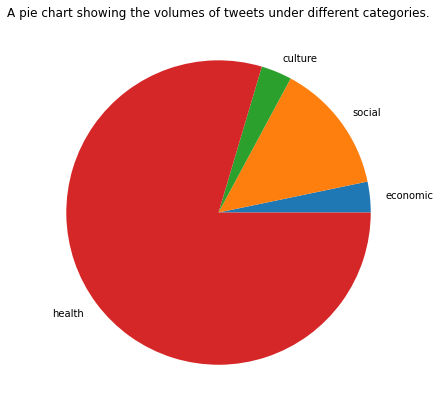

In [34]:

fig = plt.figure(figsize =(10, 7)) 
a = pivot_clusters.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show() 

C:\Users\aross\AppData\Local\Temp\ipykernel_105956\2793795951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e.drop(e.head(2).index, inplace=True)


Text(0, 0.5, 'total tweets')

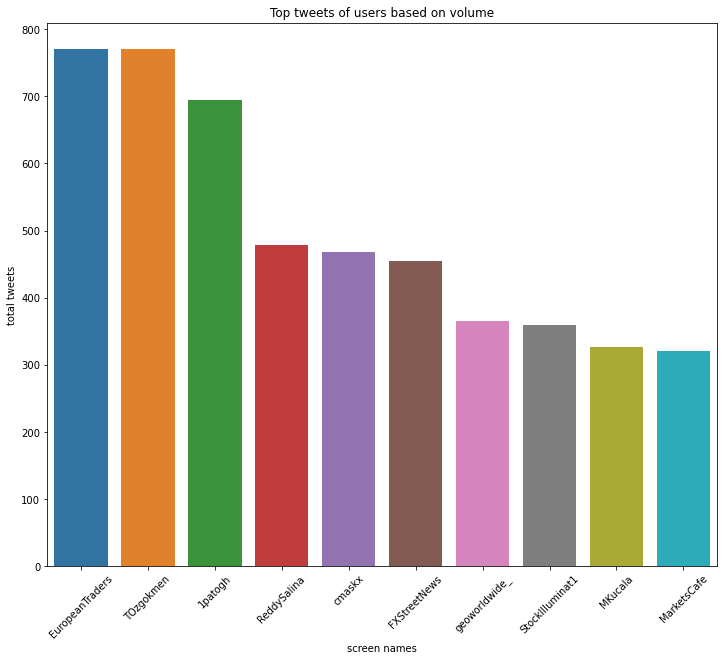

In [35]:
# Users with the most tweets in dataset

d = pivot_clusters.sort_values(by = 'total', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)

plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.total)
plt.title('Top tweets of users based on volume')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('total tweets')

C:\Users\aross\AppData\Local\Temp\ipykernel_105956\3024495292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e.drop(e.head(1).index, inplace=True)


Text(0, 0.5, 'economy tweets')

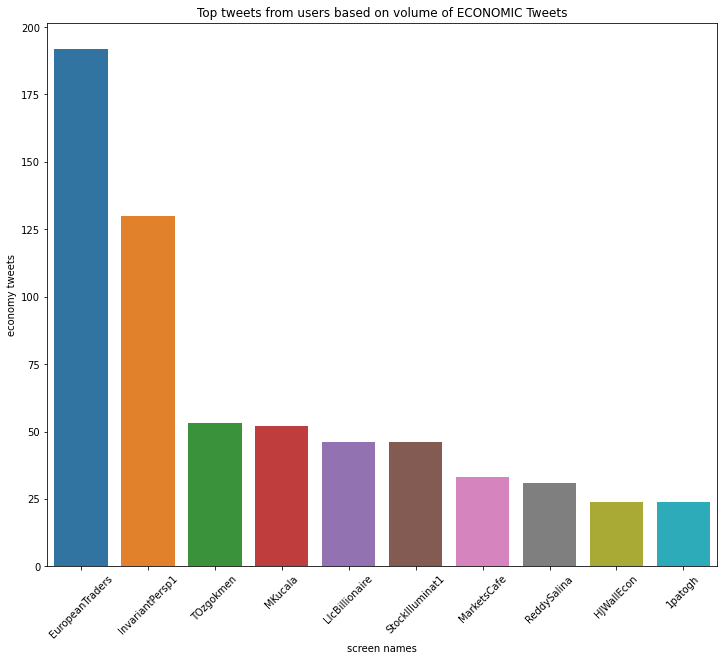

In [36]:
# Users with most economy tweets

d = pivot_clusters.sort_values(by = 'economic', ascending  = False)
e = d.head(11)
e.drop(e.head(1).index, inplace=True)

plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.economic)
plt.title('Top tweets from users based on volume of ECONOMIC Tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('economy tweets')

C:\Users\aross\AppData\Local\Temp\ipykernel_105956\2626418104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e.drop(e.head(2).index, inplace=True)


Text(0, 0.5, 'social tweets')

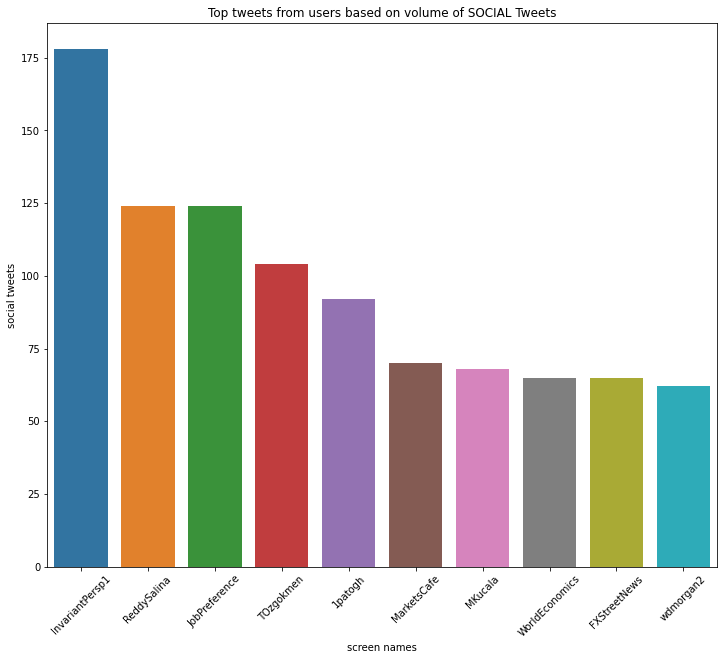

In [37]:
# Users with most social tweets

d = pivot_clusters.sort_values(by = 'social', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)


plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.social)
plt.title('Top tweets from users based on volume of SOCIAL Tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('social tweets')

C:\Users\aross\AppData\Local\Temp\ipykernel_105956\1054649620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e.drop(e.head(1).index, inplace=True)


Text(0, 0.5, 'culture tweets')

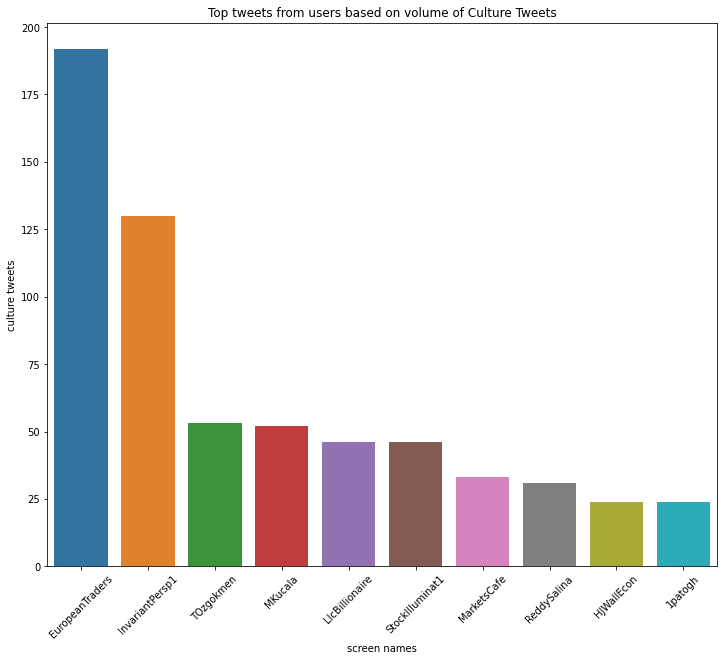

In [38]:
# Users with most culture tweets

d = pivot_clusters.sort_values(by = 'culture', ascending  = False)
e = d.head(11)
e.drop(e.head(1).index, inplace=True)


plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.culture)
plt.title('Top tweets from users based on volume of Culture Tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('culture tweets')

C:\Users\aross\AppData\Local\Temp\ipykernel_105956\1101869456.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e.drop(e.head(2).index, inplace=True)


Text(0, 0.5, 'health tweets')

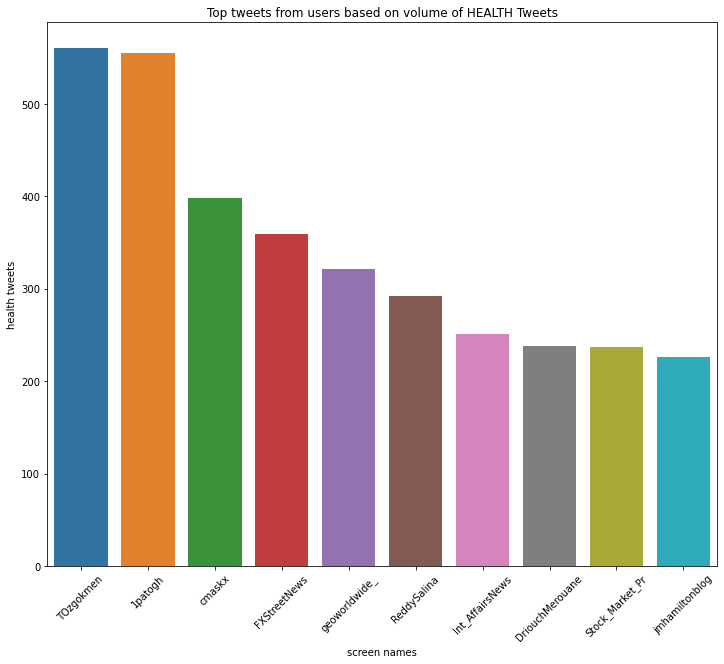

In [39]:
# Users with most health tweets

d = pivot_clusters.sort_values(by = 'health', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)


plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.health)
plt.title('Top tweets from users based on volume of HEALTH Tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('health tweets')

Distribution test and skewness

In [40]:
from statistics import mean
import re
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler

In [41]:
# drop the totals row.
print(pivot_clusters.shape)
pivot_clusters.drop(pivot_clusters.tail(1).index,inplace=True)
print(pivot_clusters.shape)

(243660, 5)
(243659, 5)


ECONOMIC

C:\Users\aross\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.07 and sigma = 0.68



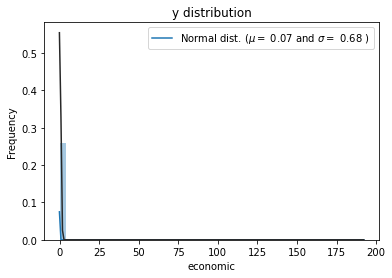

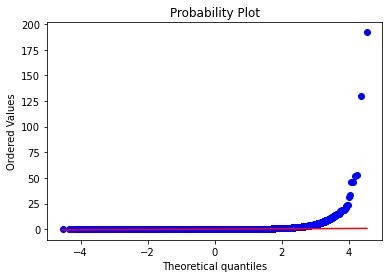

In [42]:
# Target variable
sns.distplot(pivot_clusters.economic , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.economic)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plot the distribution
plt.title('Ecocnomy tweets distribution plot')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.economic, plot=plt)
plt.show()

SOCIAL

C:\Users\aross\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.28 and sigma = 1.25



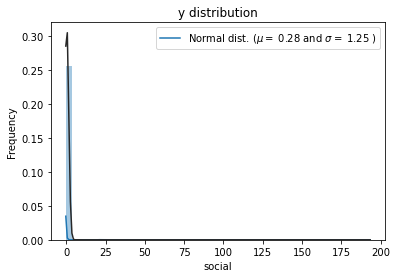

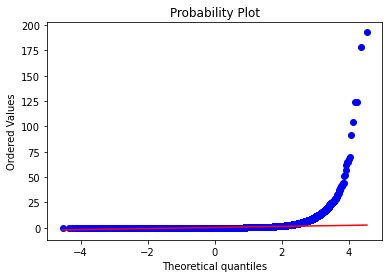

In [43]:
# Target variable
sns.distplot(pivot_clusters.social , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.social)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Social tweets distribution plot')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.social, plot=plt)
plt.show()

CULTURE

C:\Users\aross\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.07 and sigma = 0.68



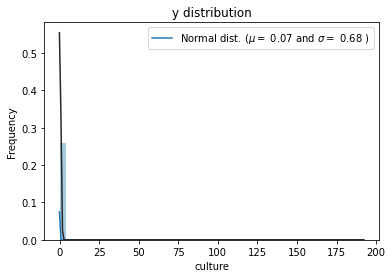

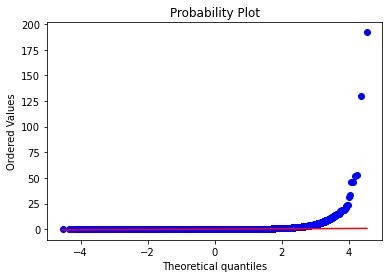

In [44]:
# Target variable
sns.distplot(pivot_clusters.culture , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.culture)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Culture tweets distribution plot')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.culture, plot=plt)
plt.show()

HEALTH

C:\Users\aross\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 1.61 and sigma = 5.01



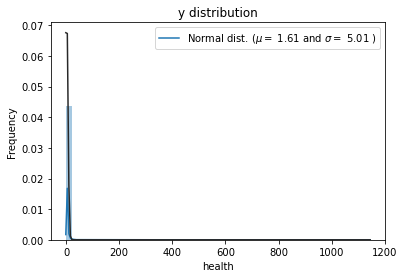

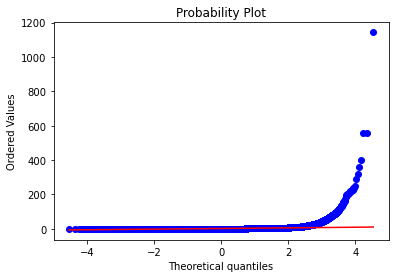

In [45]:
# Target variable
sns.distplot(pivot_clusters.health , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.health)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Health tweets distribution plot')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.health, plot=plt)
plt.show()

KMeans Clustering.
'Distance computation in k-Means weights each dimension equally and hence care must be taken to ensure that unit of dimension shouldn’t distort relative near-ness of observations. Common method is to unit-standardize each dimension individually.' The unit for the tweets are the same, therefore no need.

In [46]:
from sklearn.cluster import KMeans

2D Clusters.

* Socio-Economic

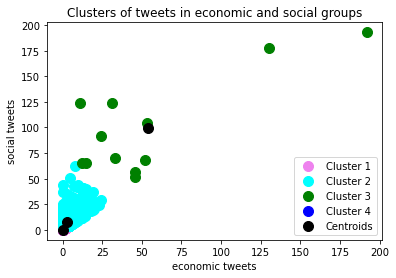

In [47]:
# fitting kmeans to dataset
X = pivot_clusters[['economic', 'social']].values
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in economic and social groups')
plt.xlabel('economic tweets')
plt.ylabel('social tweets')
plt.legend()
plt.show()


* Socio-Culture

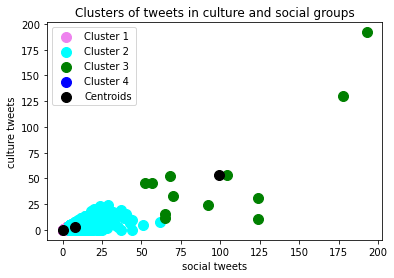

In [48]:
# fitting kmeans to dataset
X = pivot_clusters[['social', 'culture']].values
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in culture and social groups')
plt.xlabel('social tweets')
plt.ylabel('culture tweets')
plt.legend()
plt.show()

* Socio-Health


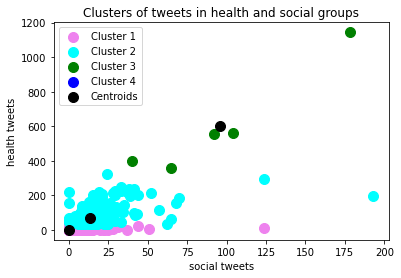

In [49]:
# fitting kmeans to dataset
X = pivot_clusters[['social', 'health']].values
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in health and social groups')
plt.xlabel('social tweets')
plt.ylabel('health tweets')
plt.legend()
plt.show()

* Economic-health

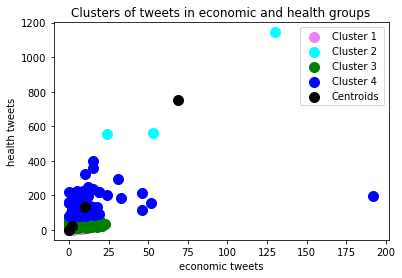

In [50]:
# fitting kmeans to dataset
X = pivot_clusters[['economic', 'health']].values
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in economic and health groups')
plt.xlabel('economic tweets')
plt.ylabel('health tweets')
plt.legend()
plt.show()

Economic-Culture

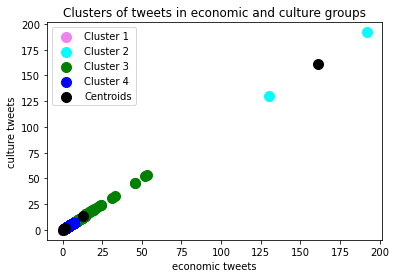

In [51]:
# fitting kmeans to dataset
X = pivot_clusters[['economic', 'culture']].values
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in economic and culture groups')
plt.xlabel('economic tweets')
plt.ylabel('culture tweets')
plt.legend()
plt.show()

Health-Culture


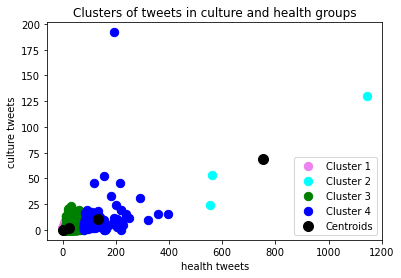

In [52]:
# fitting kmeans to dataset
X = pivot_clusters[['health', 'culture']].values
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=70, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=70, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=70, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=70, c='blue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in culture and health groups')
plt.xlabel('health tweets')
plt.ylabel('culture tweets')
plt.legend()
plt.show()

KMeans with PCA

In [53]:
from sklearn.decomposition import PCA

In [54]:
seg = pivot_clusters.copy()
# seg = seg.drop

pca = PCA()
pca.fit(seg)

PCA()

In [55]:
pca.explained_variance_ratio_

array([9.72726055e-01, 2.38210732e-02, 3.45287166e-03, 2.02752999e-27,
       2.43620730e-35])

Text(0, 0.5, 'cummulative explained variance')

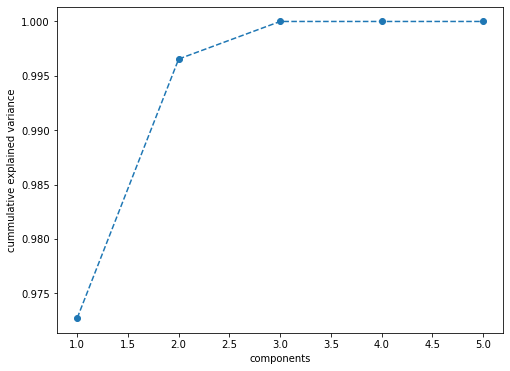

In [56]:
plt.figure(figsize = (8,6))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')

In [57]:
pca = PCA(n_components = 2)
pca.fit(seg)

PCA(n_components=2)

In [58]:
scores = pca.transform(seg)

In [59]:
n = 4
kmeans_pca = KMeans(n_clusters = n, init = 'k-means++', random_state = 0)
kmeans_pca.fit(scores)

KMeans(n_clusters=4, random_state=0)

In [60]:
c = pd.concat([seg.reset_index(drop = True), pd.DataFrame(scores)], axis = 1)
c.columns.values[-2:] = ['component1', 'component2']
c['segment_kmeans_pca'] = kmeans_pca.labels_

In [61]:
c.tail()

,economic,social,culture,health,total,component1,component2,segment_kmeans_pca
243654,0,0,0,1,1,-1.209080,-0.140540,0
243655,0,0,0,2,2,0.171118,-0.448606,0
243656,0,0,0,0,0,-2.589277,0.167525,0
243657,1,10,1,4,16,13.885576,8.848696,0
243658,0,1,0,5,6,5.233956,-0.512560,0


Text(0.5, 1.0, 'Clusters by PCA')

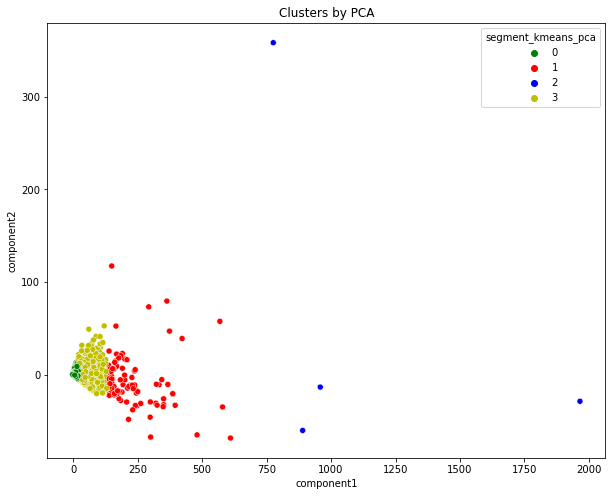

In [62]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = c['component1'], y = c['component2'], hue = c['segment_kmeans_pca'], palette = ['g', 'r', 'b', 'y'])
plt.title('Clusters by PCA')

In [63]:
tweets = pd.read_csv("Recession-June-July-500k-Tweets.csv")

In [64]:
tweets.head()

,Unnamed: 0,User,Date Created,Tweet,Favourite Count,Number of Likes,Retweeet Count,Reply Count,Retweeted Tweet,Language
0,0,Makarov_Igor,2022-07-28 23:59:59+00:00,"It is sad, but we are officially in #recession...",98,0,0,0,NaN,en
1,1,quail_jay,2022-07-28 23:59:56+00:00,@tedcruz Orwell said the greatest threat by so...,1896,0,0,0,NaN,en
2,2,ShibaInuOnly,2022-07-28 23:59:55+00:00,Glad to be part of the 1% that remains bullish...,5,7,2,0,NaN,en
3,3,BenSpin2,2022-07-28 23:59:55+00:00,@HawleyMO I think we'll call this the Hawley r...,9,0,0,0,NaN,en
4,4,RJCass1,2022-07-28 23:59:55+00:00,"@ArowynPitts @BCozatt @MarshaBlackburn FYI, ge...",9092,1,0,0,NaN,en


In [65]:
'''create a scores column, sort values by scores, do analysis on top 500 tweets'''

tweets['scores'] = tweets['Number of Likes'] + tweets["Retweeet Count"] + tweets['Reply Count']
top_tweets = tweets.sort_values(by = 'scores', ascending = False)
top_tweets.head()

,Unnamed: 0,User,Date Created,Tweet,Favourite Count,Number of Likes,Retweeet Count,Reply Count,Retweeted Tweet,Language,scores
210246,210246,DonaldJTrumpJr,2022-07-25 12:24:18+00:00,Apparently The White House is changing the def...,27508,74318,12558,6189,NaN,en,93065
119961,119961,ConanOBrien,2022-07-27 18:20:13+00:00,The White House now says it’s only a recession...,1,71836,8465,1789,NaN,en,82090
131703,131703,Jim_Jordan,2022-07-27 12:31:04+00:00,"If you’re not worried about a recession, why c...",4262,47585,7660,6057,NaN,en,61302
208209,208209,laurenboebert,2022-07-25 13:35:51+00:00,"If we weren’t in a recession, the White House ...",4552,46430,8650,3181,NaN,en,58261
92519,92519,Jim_Jordan,2022-07-28 12:34:09+00:00,Recession.,4262,38188,5536,12776,NaN,en,56500


In [66]:
#explore the time stamps and create groups

top_tweets['Date Created'] = pd.to_datetime(top_tweets['Date Created'])

In [67]:

top_tweets.head()

,Unnamed: 0,User,Date Created,Tweet,Favourite Count,Number of Likes,Retweeet Count,Reply Count,Retweeted Tweet,Language,scores
210246,210246,DonaldJTrumpJr,2022-07-25 12:24:18+00:00,Apparently The White House is changing the def...,27508,74318,12558,6189,NaN,en,93065
119961,119961,ConanOBrien,2022-07-27 18:20:13+00:00,The White House now says it’s only a recession...,1,71836,8465,1789,NaN,en,82090
131703,131703,Jim_Jordan,2022-07-27 12:31:04+00:00,"If you’re not worried about a recession, why c...",4262,47585,7660,6057,NaN,en,61302
208209,208209,laurenboebert,2022-07-25 13:35:51+00:00,"If we weren’t in a recession, the White House ...",4552,46430,8650,3181,NaN,en,58261
92519,92519,Jim_Jordan,2022-07-28 12:34:09+00:00,Recession.,4262,38188,5536,12776,NaN,en,56500


In [68]:
top_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500001 entries, 210246 to 250000
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   Unnamed: 0       500001 non-null  int64              
 1   User             500001 non-null  object             
 2   Date Created     500001 non-null  datetime64[ns, UTC]
 3   Tweet            500001 non-null  object             
 4   Favourite Count  500001 non-null  int64              
 5   Number of Likes  500001 non-null  int64              
 6   Retweeet Count   500001 non-null  int64              
 7   Reply Count      500001 non-null  int64              
 8   Retweeted Tweet  0 non-null       float64            
 9   Language         500001 non-null  object             
 10  scores           500001 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(6), object(3)
memory usage: 45.8+ MB


In [69]:
top_tweets['Date Created'].describe()

C:\Users\aross\AppData\Local\Temp\ipykernel_105956\2995151116.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  top_tweets['Date Created'].describe()


count                        500001
unique                       392044
top       2022-07-26 13:16:01+00:00
freq                             19
first     2022-06-25 08:34:00+00:00
last      2022-07-28 23:59:59+00:00
Name: Date Created, dtype: object

In [70]:
# Add columns with year, month, and weekday name
top_tweets['Year'] = pd.DatetimeIndex(top_tweets['Date Created']).year
top_tweets['Month'] = pd.DatetimeIndex(top_tweets['Date Created']).month
top_tweets['Weekday'] = pd.DatetimeIndex(top_tweets['Date Created']).weekday

top_tweets.head(20)


,Unnamed: 0,User,Date Created,Tweet,Favourite Count,Number of Likes,Retweeet Count,Reply Count,Retweeted Tweet,Language,scores,Year,Month,Weekday
210246,210246,DonaldJTrumpJr,2022-07-25 12:24:18+00:00,Apparently The White House is changing the def...,27508,74318,12558,6189,NaN,en,93065,2022,7,0
119961,119961,ConanOBrien,2022-07-27 18:20:13+00:00,The White House now says it’s only a recession...,1,71836,8465,1789,NaN,en,82090,2022,7,2
131703,131703,Jim_Jordan,2022-07-27 12:31:04+00:00,"If you’re not worried about a recession, why c...",4262,47585,7660,6057,NaN,en,61302,2022,7,2
208209,208209,laurenboebert,2022-07-25 13:35:51+00:00,"If we weren’t in a recession, the White House ...",4552,46430,8650,3181,NaN,en,58261,2022,7,0
92519,92519,Jim_Jordan,2022-07-28 12:34:09+00:00,Recession.,4262,38188,5536,12776,NaN,en,56500,2022,7,3
192004,192004,RoryStewartUK,2022-07-25 20:30:45+00:00,And again Liz Truss keeps saying Levelling up...,7699,46150,7969,1312,NaN,en,55431,2022,7,0
92552,92552,cvpayne,2022-07-28 12:34:04+00:00,Breaking News: Folks We Are In Recession\n2Q22...,24126,33739,7473,1761,NaN,en,42973,2022,7,3
436486,436486,thebradfordfile,2022-07-01 21:26:15+00:00,Biden owns this recession. He is the worst pre...,125517,34521,4721,1017,NaN,en,40259,2022,7,4
60758,60758,DavidSacks,2022-07-28 14:55:20+00:00,A lot of people are wondering about the defini...,29903,31210,5817,854,NaN,en,37881,2022,7,3
88274,88274,JackPosobiec,2022-07-28 12:46:37+00:00,Recession is when your neighbor loses his job\...,118572,29859,6561,414,NaN,en,36834,2022,7,3


In [71]:
top_tweets.to_csv('WeekdayColumns.csv')

# Weekday Analysis overall tweets

In [72]:
# week day analysis
weeks_df = top_tweets.groupby(['Weekday']).count() 
weeks_df = weeks_df[['Tweet']]
weeks_df.reset_index(inplace=True)
dict_map = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
weeks_df['Weekday'] = weeks_df['Weekday'].replace(dict_map)
weeks_df

,Weekday,Tweet
0,Sunday,67723
1,Monday,82776
2,Tuesday,83170
3,Wednesday,154192
4,Thursday,46116
5,Friday,31536
6,Saturday,34488


Unfortunately, this dataset is to small to show a weekly analysis since all tweets scraped are from July 18th 2022. We will need extremely larger data sets in order to get a time series analysis. 10,000 Tweets appears to be quite small.

Text(0, 0.5, 'Number of Tweets')

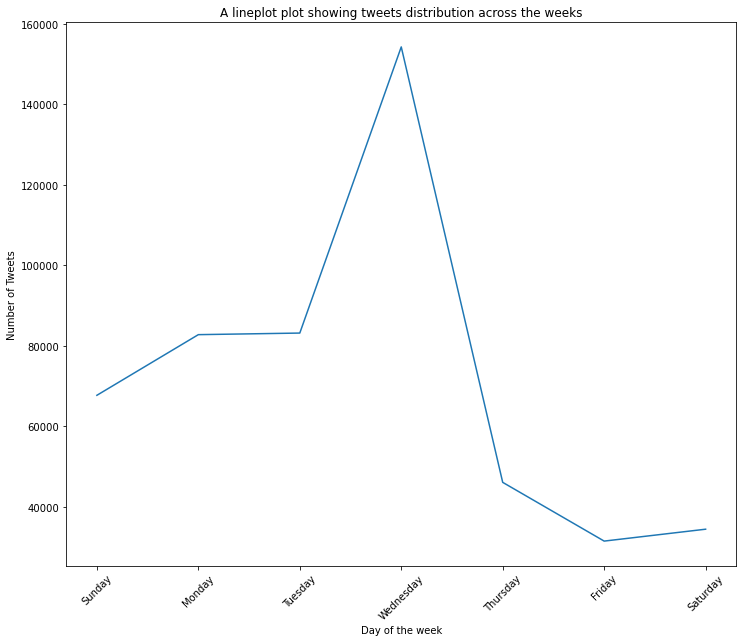

In [75]:
#sorter = ['0', '1', '2', '3', '4', '5', '6']
#sorterIndex = dict(zip(sorter,range(len(sorter))))

weeks_df['Day_id'] = weeks_df.index
#weeks_df['Day_id'] = weeks_df['Day_id'].map(sorterIndex)
weeks_df.sort_values('Day_id', inplace=True)


# now lets see some of the busy days of the week.
plt.figure(figsize=(12,10))
sns.lineplot(x = weeks_df.Weekday, y = weeks_df.Tweet)
plt.title('A lineplot plot showing tweets distribution across the weeks')
plt.xticks(rotation=45)
plt.xlabel('Day of the week')
plt.ylabel('Number of Tweets')